This notebook analyzes the Boulder dataset from NIST linked https://nextg.nist.gov/submissions/112. The first half of the notebook is from tutorial #5 to process the data. 

In [2]:
import glob
from scipy.io import loadmat

import os
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

import sys

#os.chdir('/Users/davidlee/Desktop/Sionna_Boulder/geo2sigmap')
sys.path.append(os.path.abspath('./src'))
from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

ModuleNotFoundError: No module named 'scene_generation'

In [ ]:
# LOS or NLOS for measurement type
measurement_type1 = "NLOS"
measurement_type2 = "LOS"

In [ ]:
def initialize_header(measurement_type):
    # Initialize header data structure
    header_dict = {"file_name":[], "mea_idx":[]}
    header_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/Header files/".format(measurement_type)  
    header_mat_files = glob.glob(f"{header_folder_path}/*.mat")  
    print(header_mat_files[:3]) 
    return header_dict, header_folder_path, header_mat_files

In [ ]:
NLOS_header_dict, NLOS_header_folder_path, NLOS_header_mat_files = initialize_header(measurement_type1)
LOS_header_dict, LOS_header_folder_path, LOS_header_mat_files = initialize_header(measurement_type2)

['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002150hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002142hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002174hdr.mat']
['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001599hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001587hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001595hdr.mat']


In [ ]:
def extract_header_info(header_dict, header_mat_files):
    # MATLAB to Python data conversion
    for mat_file_path in header_mat_files: 

        #Load the .mat file
        data = loadmat(mat_file_path)

        # Store basic file info
        header_dict["file_name"].append(os.path.basename(mat_file_path))
        header_dict["mea_idx"].append(os.path.basename(mat_file_path)[4:4+4])

        # Recursive struct parsing
        for key in data:
            if not key.startswith("__"):  # Ignore metadata keys
                value = data[key]
                if isinstance(value, np.ndarray) and value.dtype.names:
                        for name in value.dtype.names:
                            tmp_value =  data[key][0][name]
                            try:
                                tmp_value = tmp_value.item()
                                tmp_value = tmp_value.squeeze()
                                tmp_value = tmp_value.item()
                            except Exception as e:
                                pass
                            if ("{}_{}".format(key, name)) not in header_dict:
                                header_dict[("{}_{}".format(key, name))] = []
                            header_dict[("{}_{}".format(key, name))].append(tmp_value)
                else:
                    tmp_value = data[key]
                    try:
                        tmp_value = tmp_value.item()
                        tmp_value = tmp_value.squeeze()
                        tmp_value = tmp_value.item()
                    except Exception as e:
                        pass
                    if "{}".format(key) not in header_dict:
                        header_dict[("{}".format(key))] = []
                    header_dict[("{}".format(key))].append(tmp_value)

                    
    return header_dict

In [ ]:
NLOS_header_dict = extract_header_info(NLOS_header_dict, NLOS_header_mat_files)
LOS_header_dict = extract_header_info(LOS_header_dict, LOS_header_mat_files)

In [ ]:
NLOS_header_df = pd.DataFrame(NLOS_header_dict)
LOS_header_df = pd.DataFrame(LOS_header_dict)

In [ ]:
def assert_errors(header_df):
    # Assert checks for data consistency
    assert header_df['TxData_lat_Deg'].nunique() == 1,"Error: Mupltiple TX latitudes detected"
    assert header_df['TxData_long_Deg'].nunique() == 1,"Error: Mupltiple TX longitudes detected" 
    assert header_df['TxData_alt'].nunique() == 1,"Error: Mupltiple TX altitudes detected" 

In [ ]:
assert_errors(NLOS_header_df)
assert_errors(LOS_header_df)

In [ ]:
def initialize_MPC(measurement_type):
    # Initialize MPC data structure
    mpc_dict = {"file_name":[], "mea_idx":[]}
    mpc_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/MPC files/".format(measurement_type)  
    mpc_mat_files = glob.glob(f"{mpc_folder_path}/*.mat")  
    print(mpc_mat_files[:3]) 
    return mpc_dict, mpc_folder_path, mpc_mat_files

In [ ]:
NLOS_mpc_dict, NLOS_mpc_folder_path, NLOS_mpc_mat_files = initialize_MPC(measurement_type1)
LOS_mpc_dict, LOS_mpc_folder_path, LOS_mpc_mat_files = initialize_MPC(measurement_type2)

['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2266.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2267.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2259.mat']
['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1586.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1592.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1593.mat']


In [ ]:
def format_MPC_dict(MPC_dict, MPC_mat_files):
    # MATLAB to Python data conversion
    for mat_file_path in MPC_mat_files: 

        #Load the .mat file
        data = loadmat(mat_file_path)

        # Store basic file info
        MPC_dict["file_name"].append(os.path.basename(mat_file_path))
        MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])

        # Recursive struct parsing
        for key in data:
            if not key.startswith("__"):  # Ignore metadata keys
                value = data[key]
                if isinstance(value, np.ndarray) and value.dtype.names:
                        for name in value.dtype.names:
                            tmp_value =  data[key][0][name]
                            try:
                                tmp_value = tmp_value.item()
                                tmp_value = tmp_value.squeeze()
                                tmp_value = tmp_value.item()
                            except Exception as e:
                                pass
                            if ("{}_{}".format(key, name)) not in MPC_dict:
                                MPC_dict[("{}_{}".format(key, name))] = []
                            MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
                else:
                    tmp_value = data[key]
                    try:
                        tmp_value = tmp_value.item()
                        tmp_value = tmp_value.squeeze()
                        tmp_value = tmp_value.item()
                    except Exception as e:
                        pass
                    if "{}".format(key) not in MPC_dict:
                        MPC_dict[("{}".format(key))] = []
                    MPC_dict[("{}").format(key)].append(tmp_value)

                    
    return MPC_dict

In [ ]:
NLOS_MPC_dict =  format_MPC_dict(NLOS_mpc_dict, NLOS_mpc_mat_files)
LOS_MPC_dict =  format_MPC_dict(LOS_mpc_dict, LOS_mpc_mat_files)


In [ ]:
NLOS_MPC_df = pd.DataFrame(NLOS_MPC_dict)
print(NLOS_MPC_df.iloc[0].to_string())
print("\n")

LOS_MPC_df = pd.DataFrame(LOS_MPC_dict)

file_name                                                            MPC2266.mat
mea_idx                                                                     2266
header_TxGainEffective_dBi                                                     2
header_TxHPBW_Effective_deg                                                 47.3
header_dist_m                                                          61.906189
header_NumSectors                                                              8
header_B2B_Attenuation_dB                                                    -15
MPC_params_sector01            [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02            [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03            [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04            [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05            [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_sector06         

In [ ]:
NLOS_merged_df = pd.merge(NLOS_MPC_df, NLOS_header_df, on='mea_idx', how='inner')  
print(NLOS_merged_df.iloc[0].to_string())
LOS_merged_df = pd.merge(LOS_MPC_df, LOS_header_df, on='mea_idx', how='inner')

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

In [ ]:
def generate_scene(merged_df):
    scene_dir = "./scenes/Boulder_Downtown"

    polygon_points_gps = rect_from_point_and_size(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"],
        "center", 
        512,
        512
    )
    min_lon, min_lat = polygon_points_gps[0]
    max_lon, max_lat = polygon_points_gps[2]
    print(
        f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
    )
    scene_instance = Scene()
    scene_instance(
        polygon_points_gps,
        scene_dir,
        None,
        osm_server_addr="https://overpass-api.de/api/interpreter",
        lidar_calibration=False,
        generate_building_map=True,
        ground_material_type="mat-itu_concrete",
        rooftop_material_type = "mat-itu_metal",
        wall_material_type = "mat-itu_brick"
        
    )

    utm_epsg = get_utm_epsg_code_from_gps(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"],
    )

    top_left_coord_x_utm, top_left_coord_y_utm,_  =  gps_to_utm_xy(min_lon, max_lat, utm_epsg)
    center_coord_x_utm, center_coord_y_utm, _ = gps_to_utm_xy(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"], 
        utm_epsg
    )

    scene = load_scene("{}/scene.xml".format(scene_dir), merge_shapes = False)

    # Apply transformation and store in new columns
    merged_df["GPSData_longitude_UTM"], merged_df["GPSData_latitude_UTM"], _ = zip(
        *merged_df.apply(lambda row: gps_to_utm_xy(row["GPSData_longitude_Deg"], row["GPSData_latitude_Deg"], utm_epsg), axis=1)
    )

    merged_df["Sionna_Rx_x"], merged_df["Sionna_Rx_y"] = zip(
        *merged_df.apply(lambda row: (row["GPSData_longitude_UTM"] - center_coord_x_utm, row["GPSData_latitude_UTM"] - center_coord_y_utm ), axis=1)
    )

    # Obtain the Mitsuba scene object from Sionna scene object 
    mi_scene = scene.mi_scene

    # Calculate scene bounding box excluding the ground plane
    bbox = mi.ScalarBoundingBox3f()
    for shape in mi_scene.shapes():
        if "ground" not in shape.id():
            bbox.expand(shape.bbox())

    # Generate candidate positions (with a typical UE height of 1.5m)
    # num_candidates = 1000
    candidates = np.column_stack([
        merged_df["Sionna_Rx_x"].to_numpy(),
        merged_df["Sionna_Rx_y"].to_numpy(),
        merged_df["RxData_Rxh_m"].to_numpy()
    ])

    # Create a direction vector pointing upwards (towards the sky) 
    #  and tile it to match the number of positions
    directions_np = np.tile(np.array([0, 0, 1]), (len(merged_df), 1))

    # Ray tracing validation
    rays = mi.Ray3f(
        # mi.Vector3f(candidates),
        mi.Vector3f(np.array(candidates, dtype=np.float32).T),
        mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
    )
    si = mi_scene.ray_intersect(rays)
    valid_mask = ~si.is_valid()

    merged_df["is_outdoor"] = valid_mask

    # Filter and visualize
    valid_positions = candidates[valid_mask]
    invalid_positions = candidates[~valid_mask]
    #fig = plt.figure(figsize=(10, 6))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2],c="blue",label="Valid")
    #ax.scatter(invalid_positions[:,0], invalid_positions[:,1], invalid_positions[:,2], c="red", label="Invalid" )
    # Add legend
    #ax.legend()
    #ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions out of  {len(merged_df)} Points")
    #plt.show()

    # Transmitter array (single isotropic element)
    scene.tx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",        # isotropic pattern
        polarization="V"      # vertical polarization
    )

    # Receive array (single dipole element)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="dipole",
        polarization="V"
    )

    # Transmitter configuration
    tx = Transmitter(
        name="tx",
        position=[0, 0, float(merged_df.iloc[0]["TxData_Txh_m"])],  # Elevated position
        orientation=[0, 0, 0]  
    )
    scene.add(tx)

    # Select 10 receivers form valid_positions (Outdoor positions)
    # // for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=5, replace=False)]):
    for index, row in merged_df.iterrows():
        if merged_df.iloc[index]['is_outdoor'] == True:
            rx = Receiver(
                    name=f"rx_{row['mea_idx']}",
                    position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
                    orientation=[0, 0, 0] 
                )
        # if index <= 10:
        #     rx = Receiver(
        #         name=f"rx_{row['mea_idx']}",
        #         position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
        #         orientation=[0, 0, 0] 
        #     )
            scene.add(rx)

    return scene, valid_positions

In [ ]:
import sionna.rt
from sionna.rt import SceneObject, ITURadioMaterial

def add_random_cars_to_scene(scene, num_cars, area_radius, valid_positions):
        # Radio material constituing the cars
        # Use ITU metal, and use red color for visualization to
        car_material = ITURadioMaterial("car-material",
                                        "metal",
                                        thickness=0.01,
                                        color=(0.8, 0.1, 0.1))

        # Instantiate `num_cars` cars sharing the same mesh and material
        cars = [SceneObject(fname=sionna.rt.scene.low_poly_car, # Simple mesh of a car
                        name=f"car-{i}",
                        radio_material=car_material)
                for i in range(num_cars)]

        # Add the list of newly instantiated objects to the scene
        scene.edit(add=cars)
        car_positions = []
        min_dist_rx = 2.0  # Minimum distance from any RX
        while len(car_positions) < num_cars:
                # Randomly sample a position within the defined area
                x = np.random.uniform(-area_radius, area_radius)
                y = np.random.uniform(-area_radius, area_radius)
                position = (x, y, 0)

                # Ensure x, y is not too close to the TX
                if np.linalg.norm(np.array(position) - np.array([0, 0, 0])) < min_dist_rx:
                        continue
                # Ensure x, y is not too close to any RX
                diffs = np.linalg.norm(valid_positions[:, :2] - np.array(position[:2]), axis=1)
                if np.any(diffs < min_dist_rx):
                        continue

                # Ensure the new position is not too close to existing cars
                if all(np.linalg.norm(np.array(position) - np.array(existing_pos)) >= min_dist_rx for existing_pos in car_positions):
                        car_positions.append(position)

        c = mi.Point3f(0, 0, 0)

        # Sample random coords
        x = np.random.uniform(-area_radius, area_radius, num_cars)
        y = np.random.uniform(-area_radius, area_radius, num_cars)
        z = np.zeros(num_cars)

        cars_positions = mi.Point3f(x, y, z)

        # Set positions/orientations
        for i in range(num_cars):
                cars[i].position = mi.Point3f(float(x[i]), float(y[i]), 0.0)
                cars[i].scaling = 2.0
        return scene

In [ ]:
NLOS_scene, NLOS_valid_positions = generate_scene(NLOS_merged_df)
LOS_scene, LOS_valid_positions = generate_scene(LOS_merged_df)

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 1050.67it/s]


2025-09-22 14:58:00 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 1045.91it/s]


2025-09-22 14:58:06 WARN wrk11 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [ ]:
def radio_scene(scene):
    # Configure simulation parameters
    scene.frequency = 28.5e9  
    scene.synthetic_array = True  # Optimize for array calculations

    for radio_material in scene.radio_materials.values():
        radio_material.scattering_coefficient  = 0.4

    # Perform ray tracing using PathSolver()
    solver = PathSolver()
    paths = solver(scene, 
                max_depth=2,
                los=True,
                specular_reflection=True,
                diffuse_reflection=True, 
                refraction=False,
                samples_per_src=int(1e3)
    )
    return paths


In [ ]:
NLOS_paths = radio_scene(NLOS_scene)
LOS_paths = radio_scene(LOS_scene)

In [ ]:
# Parse paths into a structured dataset containing detailed rays information
def create_ray_dataset(paths, merged_df, valid_positions, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }

    # See sionna.rt.constants.InteractionType
    ray_type_map = {0: "LOS", 1: "SPECULAR", 2: "DIFFUSE", 4: "REFRACTION"}
    
    a = np.asarray(paths.a).squeeze()
    tau = np.asarray(paths.tau).squeeze()
    types = np.asarray(paths.interactions).squeeze()
    mask = np.asarray(paths.valid).squeeze()
    phi_r = np.asarray(paths.phi_r).squeeze()
    phi_t = np.asarray(paths.phi_t).squeeze()
    theta_r = np.asarray(paths.theta_r).squeeze()
    theta_t = np.asarray(paths.theta_t).squeeze()
    targets = np.asarray(paths.targets).squeeze().T
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        # Filter out the RX if it has no valid paths
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    cur_ray_type = 0
                    num_depths = types.shape[0]
                    for depth_idx in range(num_depths-1, -1, -1):
                        cur_ray_type = types[depth_idx,idx,sub_idx]
                        # print(f"types[{depth_idx},{idx},{sub_idx}]",cur_ray_type)
                        if cur_ray_type != 0:
                            break

                    # Store the list instead of np.array to avoid the space seperator in .csv
                    dataset["freq"].append(frequency)
                    dataset["type"].append(ray_type_map[cur_ray_type])
                    z = np.complex64(a[0,idx,sub_idx] + 1j*a[1, idx,sub_idx]) 
                    dataset["a"].append(z)
                    dataset["tau"].append(tau[idx,sub_idx])

                    # Paths object only store the RX position instead of the name/idx of the RX in the Scenes Object
                    # We need to obtain the RX name by calculating the nearest RX pos due to the precision issue
                    nearest_row = merged_df.loc[
                        merged_df.apply(lambda row: (row['Sionna_Rx_x'] - targets[idx, 0])**2 + (row['Sionna_Rx_y'] - targets[idx, 1])**2, axis=1).idxmin()
                    ]
                    dataset["rx_id"].append(nearest_row["mea_idx"])
                
                    
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])                    
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
    
    return pd.DataFrame(dataset)



In [ ]:
# Generate analysis dataframe
NLOS_df = create_ray_dataset(NLOS_paths, NLOS_merged_df, NLOS_valid_positions, frequency=28.5e9)

In [ ]:
LOS_df = create_ray_dataset(LOS_paths, LOS_merged_df, LOS_valid_positions, frequency=28.5e9)

In [ ]:
def linear(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 ** (pg_arr_copy / 10)

def convert_to_db(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 * np.log10(pg_arr_copy)

def normalize_func(path_gain_arr):
    linear_pg = linear(path_gain_arr)
    max_val = np.max(linear_pg)
    linear_pg_norm = linear_pg / max_val
    return convert_to_db(linear_pg_norm)

In [ ]:
# comparison_df collects data from the strongest path ray from Sionna to compare with the strongest path ray from the Boulder data
def find_strongest_path(merged_df, df):
    comparison_df = pd.DataFrame()
    no_signal = []

    for idx, rx_id in enumerate(merged_df['mea_idx']):
        # Get real results
        merged_df_row = merged_df[merged_df['mea_idx'] == rx_id]
        if merged_df_row['is_outdoor'].iloc[0] == True:
            tmp_tau = merged_df_row["MPC_params_sector01"].values[0][:, 0]
            tmp_aoa_az = merged_df_row["MPC_params_sector01"].values[0][:, 1]
            tmp_aoa_el = merged_df_row["MPC_params_sector01"].values[0][:, 2]
            tmp_path_gain = -1.0*merged_df_row["MPC_params_sector01"].values[0][:, 3]

            strongest_pg_idx = np.argmax(tmp_path_gain)

            # Get Sionna results
            tmp_df = df[df["rx_id"] == rx_id]
            tmp_tau_sionna = (tmp_df["tau"].values * 1e9)  # Convert to nsec
            tmp_aoa_az_sionna = (90 - (tmp_df["phi_r"].values * 180 / np.pi)) % 360
            tmp_aoa_el_sionna = (90 - (tmp_df["theta_r"].values * 180 / np.pi)) % 360

            eps = 1e-12  # small constant to avoid log(0)
            tmp_path_gain_sionna = 10 * np.log10(np.abs(tmp_df["a"].values)**2 + eps)
            tmp_ray_type_sionna = tmp_df["type"]
            
            # Apply threshold
            threshold_value = -140
            mask = tmp_path_gain_sionna >= threshold_value

            # Apply mask to all arrays
            tmp_tau_sionna = tmp_tau_sionna[mask]
            tmp_aoa_az_sionna = tmp_aoa_az_sionna[mask]
            tmp_aoa_el_sionna = tmp_aoa_el_sionna[mask]
            tmp_path_gain_sionna = tmp_path_gain_sionna[mask]

            tmp_pg_norm = normalize_func(tmp_path_gain)

            if len(tmp_path_gain_sionna) > 0:
                threshold_pg_sionna_norm = normalize_func(np.array(list(tmp_path_gain_sionna)))

                # Add Strongest Rays
                strongest_sionna_pg_idx = np.argmax(tmp_path_gain_sionna)
                new_row_df = pd.DataFrame([{'rx_id':rx_id, 
                                        'Strongest PG (dB)': tmp_path_gain[strongest_pg_idx], 
                                        'AoA El': tmp_aoa_el[strongest_pg_idx] % 360,
                                        'AoA Az': tmp_aoa_az[strongest_pg_idx] % 360,
                                        'Delay (ns)': tmp_tau[strongest_pg_idx],
                                        'Strongest Sionna PG (dB)': tmp_path_gain_sionna[strongest_sionna_pg_idx],
                                        'Sionna AoA El': tmp_aoa_el_sionna[strongest_sionna_pg_idx] % 360,
                                        'Sionna AoA Az': tmp_aoa_az_sionna[strongest_sionna_pg_idx] % 360,
                                        'Sionna Delay (ns)': tmp_tau_sionna[strongest_sionna_pg_idx],
                                        'Sionna Ray Type': tmp_ray_type_sionna.iloc[strongest_sionna_pg_idx]}])
                comparison_df = pd.concat([comparison_df, new_row_df], ignore_index=True)
            else:
                no_signal.append(rx_id)
    # print(f"No Sionna data available for {len(no_signal)} rx_id(s).")
    return comparison_df, no_signal

In [ ]:
def find_top_n_paths(merged_df, df, n=3):
    comparison_df = pd.DataFrame()
    no_signal = []

    for rx_id in merged_df['mea_idx']:
        merged_df_row = merged_df[merged_df['mea_idx'] == rx_id]
        if merged_df_row['is_outdoor'].iloc[0]:
            tmp_tau = merged_df_row["MPC_params_sector01"].values[0][:, 0]
            tmp_aoa_az = merged_df_row["MPC_params_sector01"].values[0][:, 1]
            tmp_aoa_el = merged_df_row["MPC_params_sector01"].values[0][:, 2]
            tmp_path_gain = -1.0 * merged_df_row["MPC_params_sector01"].values[0][:, 3]

            # ---- TOP-n strongest from real data ----
            strongest_pg_idx = np.argsort(tmp_path_gain)[-n:][::-1]

            # Get Sionna results
            tmp_df = df[df["rx_id"] == rx_id]
            tmp_tau_sionna = (tmp_df["tau"].values * 1e9)  # Convert to nsec
            tmp_aoa_az_sionna = (90 - (tmp_df["phi_r"].values * 180 / np.pi)) % 360
            tmp_aoa_el_sionna = (90 - (tmp_df["theta_r"].values * 180 / np.pi)) % 360

            eps = 1e-12
            tmp_path_gain_sionna = 10 * np.log10(np.abs(tmp_df["a"].values)**2 + eps)
            tmp_ray_type_sionna = tmp_df["type"]

            # Apply threshold
            threshold_value = -140
            mask = tmp_path_gain_sionna >= threshold_value

            tmp_tau_sionna = tmp_tau_sionna[mask]
            tmp_aoa_az_sionna = tmp_aoa_az_sionna[mask]
            tmp_aoa_el_sionna = tmp_aoa_el_sionna[mask]
            tmp_path_gain_sionna = tmp_path_gain_sionna[mask]
            tmp_ray_type_sionna = tmp_ray_type_sionna[mask]

            if len(tmp_path_gain_sionna) > 0:
                # ---- TOP-n strongest from Sionna ----
                strongest_sionna_pg_idx = np.argsort(tmp_path_gain_sionna)[-n:][::-1]

                # Build one row for this rx_id
                row_dict = {"rx_id": rx_id}
                for i in range(min(n, len(strongest_pg_idx), len(strongest_sionna_pg_idx))):
                    row_dict.update({
                        f"Strongest PG {i+1} (dB)": tmp_path_gain[strongest_pg_idx[i]],
                        f"AoA El {i+1}": tmp_aoa_el[strongest_pg_idx[i]] % 360,
                        f"AoA Az {i+1}": tmp_aoa_az[strongest_pg_idx[i]] % 360,
                        f"Delay {i+1} (ns)": tmp_tau[strongest_pg_idx[i]],
                        f"Strongest Sionna PG {i+1} (dB)": tmp_path_gain_sionna[strongest_sionna_pg_idx[i]],
                        f"Sionna AoA El {i+1}": tmp_aoa_el_sionna[strongest_sionna_pg_idx[i]] % 360,
                        f"Sionna AoA Az {i+1}": tmp_aoa_az_sionna[strongest_sionna_pg_idx[i]] % 360,
                        f"Sionna Delay {i+1} (ns)": tmp_tau_sionna[strongest_sionna_pg_idx[i]],
                        f"Sionna Ray Type {i+1}": tmp_ray_type_sionna.iloc[strongest_sionna_pg_idx[i]]
                    })
                comparison_df = pd.concat([comparison_df, pd.DataFrame([row_dict])], ignore_index=True)
            else:
                no_signal.append(rx_id)

    return comparison_df, no_signal


In [ ]:
N = 3
NLOS_comparison_df_n, NLOS_no_signal_n = find_top_n_paths(NLOS_merged_df, NLOS_df, n=N)
LOS_comparison_df_n, LOS_no_signal_n = find_top_n_paths(LOS_merged_df, LOS_df, n=N)

In [ ]:
NLOS_comparison_df_n['Type'] = 'NLOS'
LOS_comparison_df_n['Type'] = 'LOS'

In [ ]:
merged_comparison_df_n = pd.concat([NLOS_comparison_df_n, LOS_comparison_df_n], axis=0)
merged_comparison_df_n = merged_comparison_df_n.dropna(how="any")

In [ ]:
def normalize_func_db(path_gain_arr):
    """
    Normalize path gains so that the max value becomes 0 dB.
    """
    path_gain_arr = np.array(path_gain_arr)
    return path_gain_arr - np.max(path_gain_arr)


In [ ]:
def normalize_columns(df, cols):
    # Extract the values of all selected columns
    values = df[cols].values  # shape (rows, n_cols)

    # Flatten to 1D and apply your custom normalization
    all_values_flat = values.flatten()
    normalized_flat = normalize_func_db(all_values_flat)

    # Reshape back to original shape
    norm_values = normalized_flat.reshape(values.shape)

    # Overwrite the original columns with normalized values
    df[cols] = norm_values

    return df


In [ ]:
merged_comparison_df_n

,rx_id,Strongest PG 1 (dB),AoA El 1,AoA Az 1,Delay 1 (ns),Strongest Sionna PG 1 (dB),Sionna AoA El 1,Sionna AoA Az 1,Sionna Delay 1 (ns),Sionna Ray Type 1,...,Strongest PG 3 (dB),AoA El 3,AoA Az 3,Delay 3 (ns),Strongest Sionna PG 3 (dB),Sionna AoA El 3,Sionna AoA Az 3,Sionna Delay 3 (ns),Sionna Ray Type 3,Type
0,2266,-113.576847,355.5,151.193053,384.200,-109.401520,0.451080,149.791840,381.325470,SPECULAR,...,-118.783934,7.0,209.693053,200.750,-113.768555,357.388397,220.146271,300.145233,SPECULAR,NLOS
1,2267,-113.790257,352.0,245.813161,198.300,-95.027992,0.890289,134.412598,193.210281,LOS,...,-117.997982,356.0,81.313161,217.425,-109.368927,0.456726,149.672653,376.614044,SPECULAR,NLOS
2,2265,-119.996821,5.0,229.413859,300.000,-109.328857,0.446411,150.092133,385.318146,SPECULAR,...,-120.856073,2.5,133.413859,197.475,-113.230042,357.416443,219.564667,303.399933,SPECULAR,NLOS
3,2264,-108.997424,347.5,141.897620,199.925,-110.917358,0.553993,219.397537,310.491119,SPECULAR,...,-121.694881,356.0,108.397620,213.575,-113.090202,357.477814,219.397537,310.777649,SPECULAR,NLOS
4,2248,-121.425873,0.5,178.509260,531.675,-110.147011,0.498070,210.591934,345.355347,SPECULAR,...,-122.482951,3.5,201.509260,609.300,-115.991058,34.436050,236.749283,376.633514,DIFFUSE,NLOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,2336,-75.764735,10.0,7.105804,19.075,-75.662323,8.407791,4.332085,20.531582,LOS,...,-94.480472,8.5,19.105804,21.250,-102.041161,0.966713,162.432968,177.939362,SPECULAR,LOS
46,1603,-88.936771,358.5,271.963622,81.200,-87.491524,2.124481,269.725128,80.982361,LOS,...,-104.415738,353.5,278.963622,93.200,-99.967804,324.495941,300.246490,84.233643,DIFFUSE,LOS
47,1602,-89.808938,4.5,273.814272,77.575,-87.102615,2.222023,270.403381,77.429459,LOS,...,-102.060276,6.5,186.314272,196.600,-97.653839,315.995056,328.324341,82.728951,DIFFUSE,LOS
48,2337,-74.845865,8.0,354.492166,17.850,-75.303413,8.773766,353.835907,19.681435,LOS,...,-96.597656,352.0,326.992166,27.575,-102.067322,0.967705,163.635437,177.756668,SPECULAR,LOS


In [ ]:
# Measurement PG normalization
measurement_cols = [f"Strongest PG {i+1} (dB)" for i in range(3)]
merged_comparison_df_n = normalize_columns(merged_comparison_df_n, measurement_cols)

# Sionna PG normalization
sionna_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(3)]
merged_comparison_df_n = normalize_columns(merged_comparison_df_n, sionna_cols)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_predicted_vs_measured(df, n=3, cmap="viridis"):
    fig = plt.figure(figsize=(5*n + 1, 10))  # extra width for colorbars
    fig.suptitle("Predicted vs Measured Path Gains", fontsize=16)

    # Use GridSpec to leave space for colorbars
    gs = gridspec.GridSpec(2, n + 1, width_ratios=[1]*n + [0.05], wspace=0.3, hspace=0.3)

    for j, path_type in enumerate(["LOS", "NLOS"]):
        subset = df[df["Type"] == path_type]

        # Determine min and max for axes based on this type only
        meas_cols = [f"Strongest PG {i+1} (dB)" for i in range(n)]
        pred_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(n)]
        type_min = min(subset[meas_cols].min().min(), subset[pred_cols].min().min())
        type_max = max(subset[meas_cols].max().max(), subset[pred_cols].max().max())

        for i in range(n):
            meas_col = f"Strongest PG {i+1} (dB)"
            pred_col = f"Strongest Sionna PG {i+1} (dB)"

            ax = fig.add_subplot(gs[j, i])

            sc = ax.scatter(
                subset[meas_col],
                subset[pred_col],
                c=subset[meas_col],
                cmap=cmap,
                alpha=0.8,
                vmin=type_min,
                vmax=type_max
            )

            # 1:1 reference line
            ax.plot([type_min, type_max], [type_min, type_max], "r--", lw=1)

            # Set axis limits for this type
            ax.set_xlim(type_min, type_max)
            ax.set_ylim(type_min, type_max)

            # Labels and title
            if j == 1:
                ax.set_xlabel("Measured (dB)")
            if i == 0:
                ax.set_ylabel("Predicted (dB)")
            ax.set_title(f"{path_type} - Path {i+1}")
            ax.grid(True)

        # Add a single colorbar for this row on the far right
        cax = fig.add_subplot(gs[j, -1])
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=type_min, vmax=type_max)),
            cax=cax
        )
        cbar.set_label(f"{path_type} Measured Gain (dB)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_aoa_delay_pred_vs_meas(df, n=3, cmap="viridis"):
    """
    Plot AoA azimuth and delay for the n strongest paths.
    x-axis: measured, y-axis: predicted (Sionna)
    Color-coded by strongest path gain.
    """
    features = {
        "AoA Azimuth (deg)": [(f"AoA Az {i+1}", f"Sionna AoA Az {i+1}") for i in range(n)],
        "Delay (ns)": [(f"Delay {i+1} (ns)", f"Sionna Delay {i+1} (ns)") for i in range(n)]
    }

    for feature_name, cols in features.items():
        fig = plt.figure(figsize=(5*n + 1, 10))
        fig.suptitle(f"{feature_name} of Dominant Paths", fontsize=16)

        gs = gridspec.GridSpec(2, n + 1, width_ratios=[1]*n + [0.05], wspace=0.3, hspace=0.3)

        for j, path_type in enumerate(["LOS", "NLOS"]):
            subset = df[df["Type"] == path_type]

            # Determine axis limits for this type
            type_min = min(subset[[m for m, p in cols]].min().min(),
                           subset[[p for m, p in cols]].min().min())
            type_max = max(subset[[m for m, p in cols]].max().max(),
                           subset[[p for m, p in cols]].max().max())

            for i, (meas_col, pred_col) in enumerate(cols):
                ax = fig.add_subplot(gs[j, i])

                sc = ax.scatter(
                    subset[meas_col],       # x-axis: measured
                    subset[pred_col],       # y-axis: predicted
                    c=subset[f"Strongest PG {i+1} (dB)"],  # color-coded by strongest PG
                    cmap=cmap,
                    alpha=0.8,
                    vmin=subset[[f"Strongest PG {k+1} (dB)" for k in range(n)]].min().min(),
                    vmax=subset[[f"Strongest PG {k+1} (dB)" for k in range(n)]].max().max()
                )

                # 1:1 reference line
                ax.plot([type_min, type_max], [type_min, type_max], "r--", lw=1)

                ax.set_xlim(type_min, type_max)
                ax.set_ylim(type_min, type_max)
                ax.set_xlabel("Measured")
                if i == 0:
                    ax.set_ylabel("Predicted")
                ax.set_title(f"{path_type} - Path {i+1}")
                ax.grid(True)

            # Colorbar for this row
            cax = fig.add_subplot(gs[j, -1])
            cbar = fig.colorbar(
                plt.cm.ScalarMappable(
                    cmap=cmap,
                    norm=plt.Normalize(
                        vmin=subset[[f"Strongest PG {k+1} (dB)" for k in range(n)]].min().min(),
                        vmax=subset[[f"Strongest PG {k+1} (dB)" for k in range(n)]].max().max()
                    )
                ),
                cax=cax
            )
            cbar.set_label(f"{path_type} Path Gain (dB)")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


/var/folders/72/2dlnb79j6ns37f30m_rkk9j40000gn/T/ipykernel_51978/1182376570.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


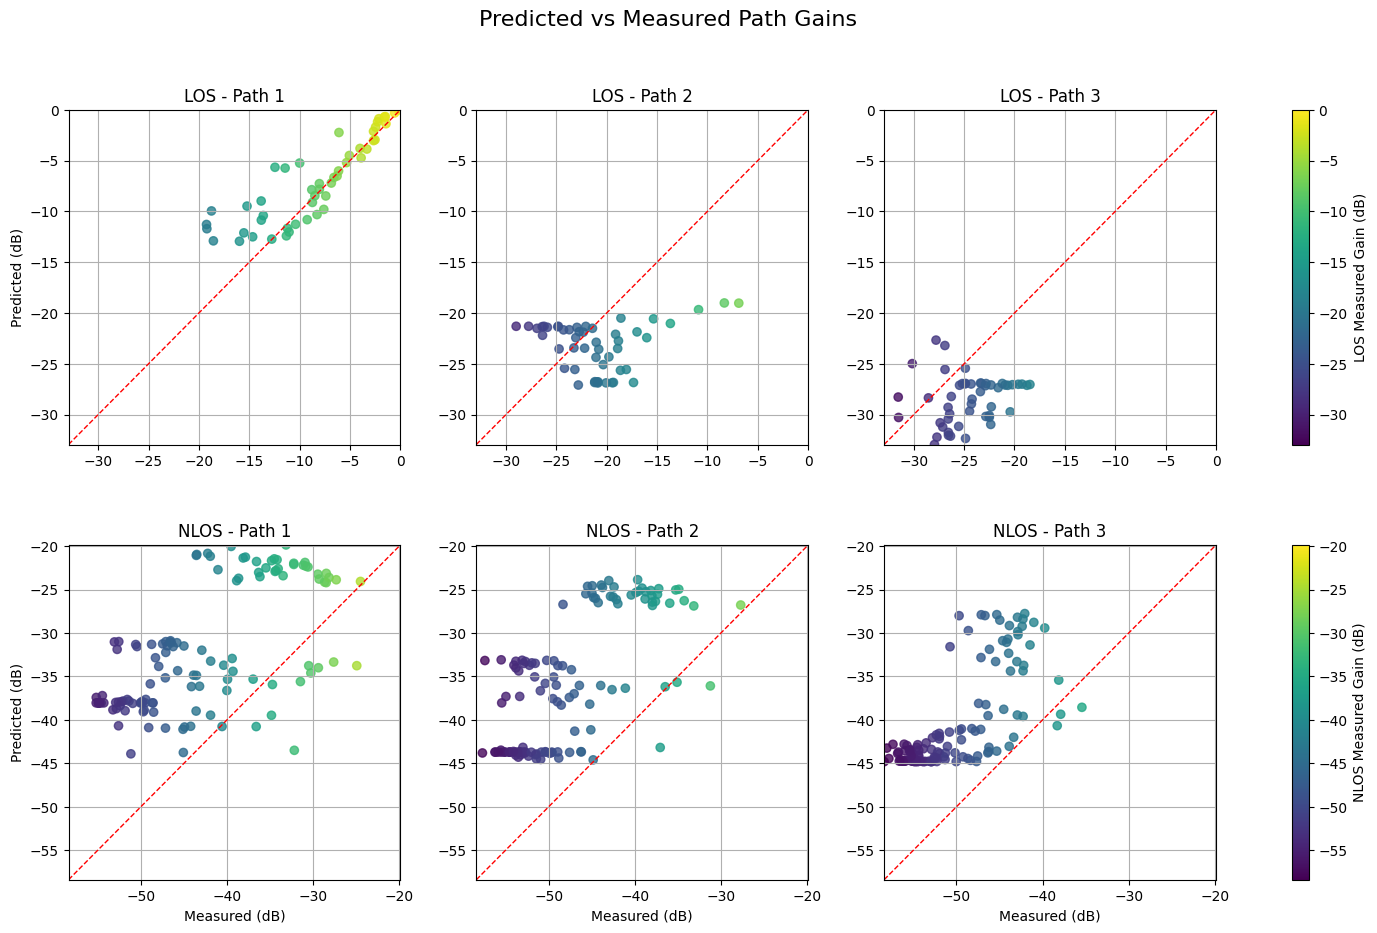

In [ ]:
plot_predicted_vs_measured(merged_comparison_df_n, n=N)

/var/folders/72/2dlnb79j6ns37f30m_rkk9j40000gn/T/ipykernel_51978/1446917025.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


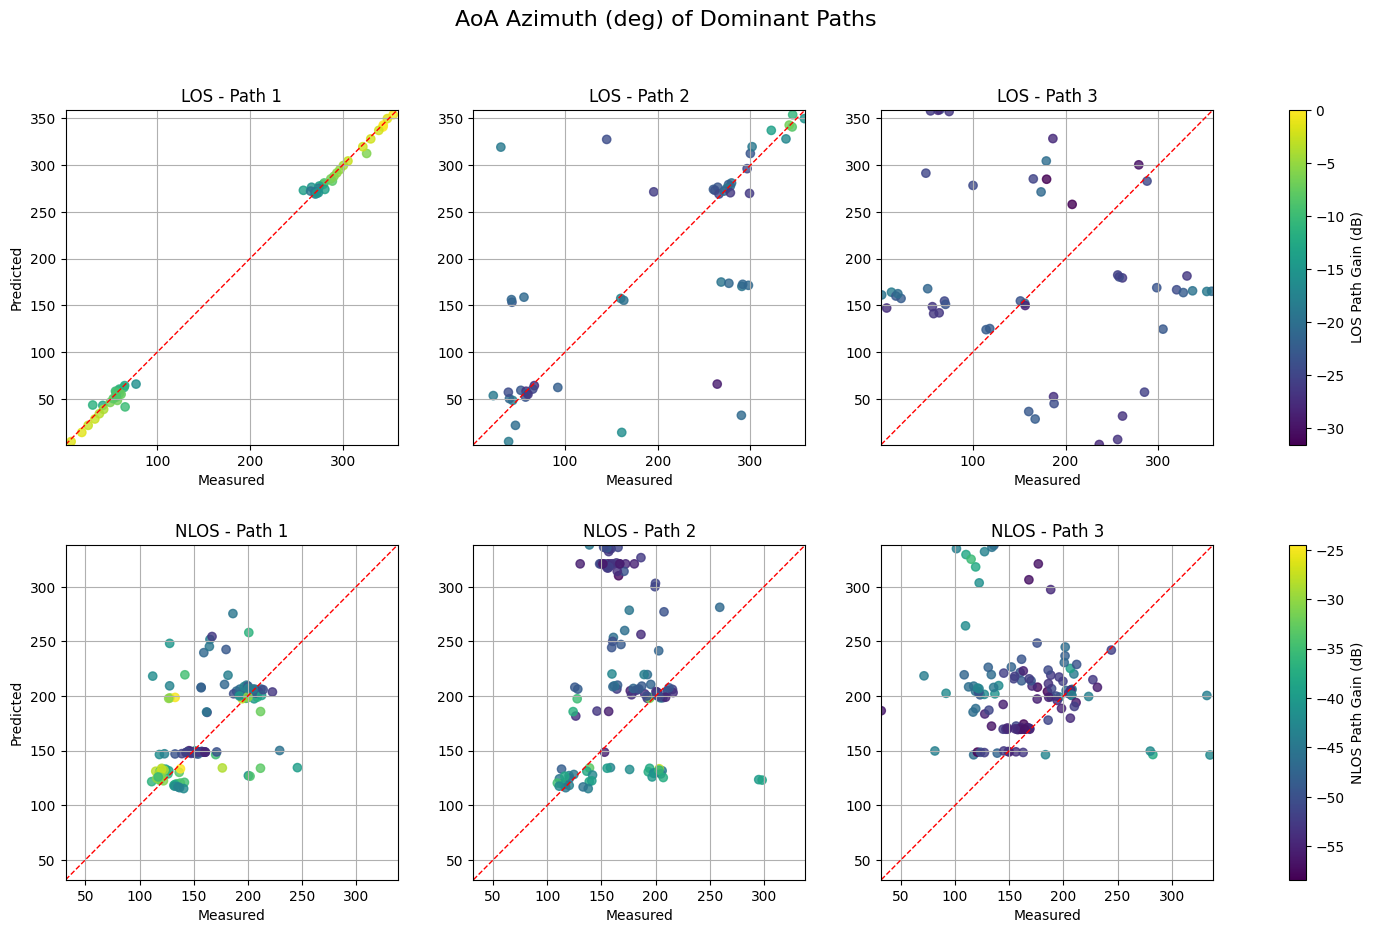

/var/folders/72/2dlnb79j6ns37f30m_rkk9j40000gn/T/ipykernel_51978/1446917025.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


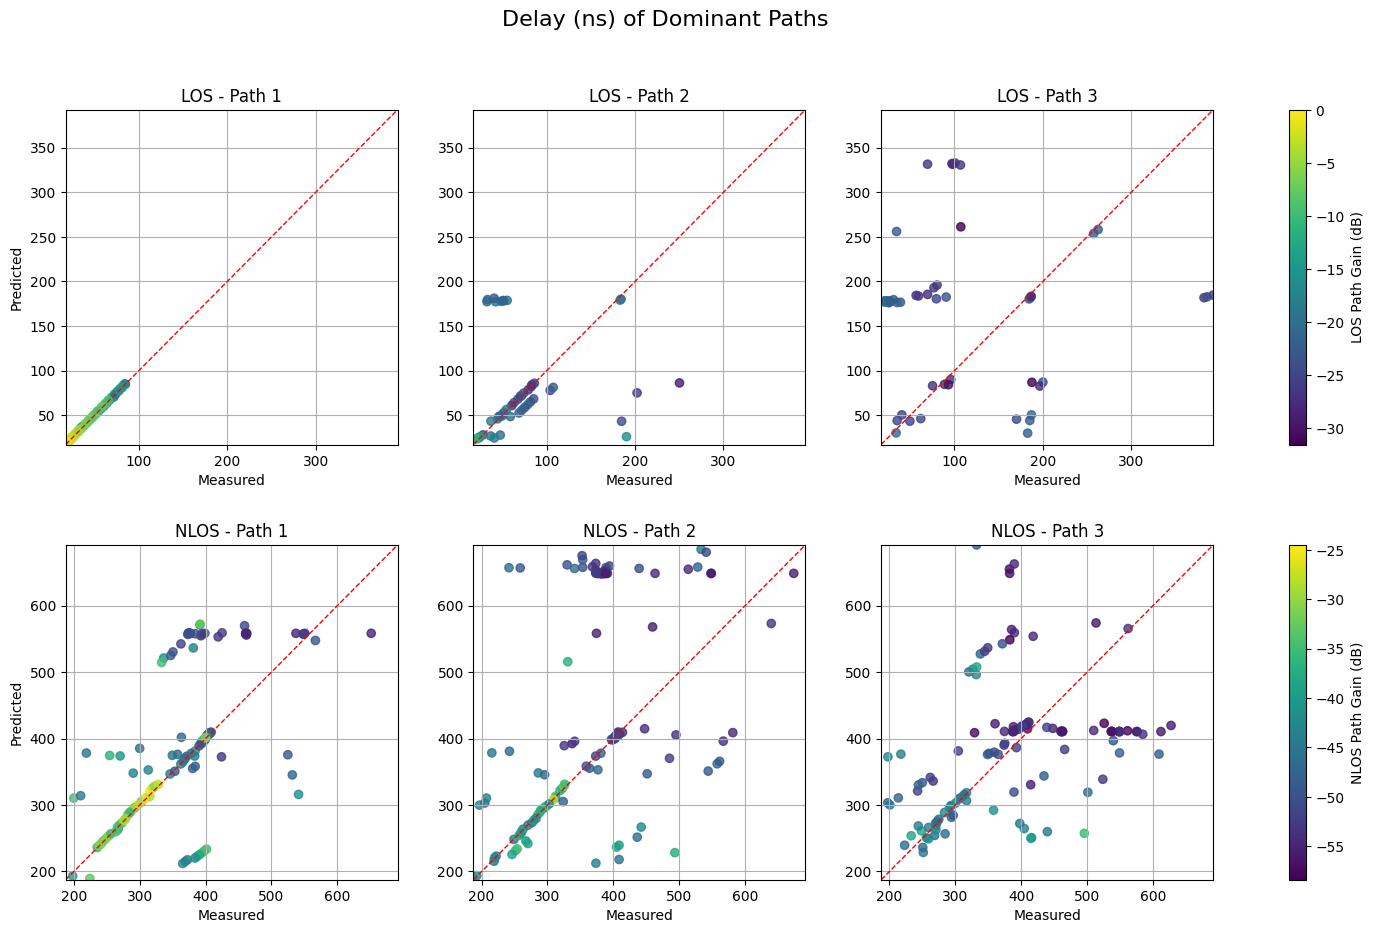

In [ ]:
plot_aoa_delay_pred_vs_meas(merged_comparison_df_n, n=N)

In [ ]:
NLOS_scene, NLOS_valid_positions = generate_scene(NLOS_merged_df)
LOS_scene, LOS_valid_positions = generate_scene(LOS_merged_df)

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 995.27it/s]


2025-09-22 15:06:55 WARN wrk10 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 945.60it/s]


2025-09-22 15:07:03 WARN wrk10 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [ ]:
# import random
# import pandas as pd
# import numpy as np
# from sionna.rt import ITURadioMaterial, PathSolver

# material_names = [
#     "concrete", "brick", "wood", "glass", "ceiling_board",
#     "chipboard", "plywood", "marble", "metal"
# ]

# num_iterations = 2  # number of random material combinations to try
# best_rmse = float("inf")
# best_material_assignment = None
# best_df = None

# # Step 1: Create one material object per type (reuse later)
# material_objects = {}
# for mat_name in material_names:
#     material_objects[mat_name] = ITURadioMaterial(
#         name=f"{mat_name}_mat",
#         itu_type=mat_name,
#         scattering_coefficient=0.4,
#         thickness=0.1
#     )

# for it in range(num_iterations):
#     # Step 2: Randomly assign materials to scene objects
#     scene_assignment = {}
#     for obj_name in LOS_scene.objects:
#         mat_type = random.choice(material_names)
#         mat_obj = material_objects[mat_type]
#         LOS_scene.get(obj_name).radio_material = mat_obj
#         scene_assignment[obj_name] = mat_type
#     print("Starting ray tracing for iteration", it+1)
#     # Step 3: Run ray-tracing solver
#     solver = PathSolver()
#     paths = solver(
#         scene=LOS_scene,
#         max_depth=2,
#         los=True,
#         specular_reflection=True,
#         diffuse_reflection=True,
#         refraction=False,
#         samples_per_src=int(1e3)
#     )
#     print("Completed ray tracing for iteration", it+1)
#     frequency=28.5e9
#     # Step 4: Get ray dataset
#     df = create_ray_dataset(paths, LOS_merged_df, LOS_valid_positions, frequency)

#     # Step 5: Compare top-n paths with measurement
#     comparison_df, no_signal_n = find_top_n_paths(LOS_merged_df, df)

#     # Normalize measurement PG
#     measurement_cols = [f"Strongest PG {i+1} (dB)" for i in range(3)]
#     merged_comparison_df_n = normalize_columns(comparison_df, measurement_cols)

#     # Normalize Sionna PG
#     sionna_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(3)]
#     comparison_df = normalize_columns(comparison_df, sionna_cols)

#     # Step 6: Compute RMSE between top-3 paths
#     #measurement_lin = 10**(merged_comparison_df_n[measurement_cols].values / 10)
#     #sionna_lin = 10**(comparison_df[sionna_cols].values / 10)
#     rmse_db = np.sqrt(np.mean((merged_comparison_df_n[measurement_cols].values - comparison_df[sionna_cols].values)**2, axis=0)) 
#     print("\nRMSE for each Path:", rmse_db)
#     weights = np.array([0.3, 0.4, 0.2])
#     rmse_db = np.sum(rmse_db * weights)
#     print(rmse_db)

#     #print(f"Iteration {it+1}, RMSE = {rmse_db:.3f}")

#     # Step 7: Save the best combination
#     if rmse_db < best_rmse:
#         best_rmse = rmse_db
#         best_material_assignment = scene_assignment.copy()
#         best_df = comparison_df.copy()

# print("\nBest RMSE:", best_rmse)
# print("Best material assignment:", best_material_assignment)


Starting ray tracing for iteration 1
Completed ray tracing for iteration 1

RMSE for each Path: [3.06613893 6.07092669 4.95018656]
4.338249667485536
Starting ray tracing for iteration 2
Completed ray tracing for iteration 2

RMSE for each Path: [3.06613893 6.39286726 6.54698203]
4.786384988553359

Best RMSE: 4.338249667485536
Best material assignment: {'ground': 'marble', 'building_0_rooftop': 'ceiling_board', 'building_0_wall': 'wood', 'building_1_rooftop': 'marble', 'building_1_wall': 'plywood', 'building_2_rooftop': 'brick', 'building_2_wall': 'brick', 'building_3_rooftop': 'glass', 'building_3_wall': 'glass', 'building_4_rooftop': 'chipboard', 'building_4_wall': 'plywood', 'building_5_rooftop': 'marble', 'building_5_wall': 'ceiling_board', 'building_6_rooftop': 'ceiling_board', 'building_6_wall': 'brick', 'building_7_rooftop': 'brick', 'building_7_wall': 'concrete', 'building_8_rooftop': 'ceiling_board', 'building_8_wall': 'ceiling_board', 'building_9_rooftop': 'concrete', 'buildin

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_comp_PG(df, n=3, cmap="viridis"):
    fig = plt.figure(figsize=(5*n + 1, 5))  # smaller height since only one row
    fig.suptitle("Predicted vs Measured Path Gains", fontsize=16)

    # Use GridSpec to leave space for colorbar
    gs = gridspec.GridSpec(1, n + 1, width_ratios=[1]*n + [0.05], wspace=0.3, hspace=0.3)

    meas_cols = [f"Strongest PG {i+1} (dB)" for i in range(n)]
    pred_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(n)]

    # Determine global min and max for axes
    type_min = min(df[meas_cols].min().min(), df[pred_cols].min().min())
    type_max = max(df[meas_cols].max().max(), df[pred_cols].max().max())

    for i in range(n):
        meas_col = f"Strongest PG {i+1} (dB)"
        pred_col = f"Strongest Sionna PG {i+1} (dB)"

        ax = fig.add_subplot(gs[0, i])

        sc = ax.scatter(
            df[meas_col],
            df[pred_col],
            c=df[meas_col],
            cmap=cmap,
            alpha=0.8,
            vmin=type_min,
            vmax=type_max
        )

        # 1:1 reference line
        ax.plot([type_min, type_max], [type_min, type_max], "r--", lw=1)

        # Axis limits
        ax.set_xlim(type_min, type_max)
        ax.set_ylim(type_min, type_max)

        # Labels and title
        ax.set_xlabel("Measured (dB)")
        ax.set_ylabel("Predicted (dB)")
        ax.set_title(f"Path {i+1}")
        ax.grid(True)

    # Add a single colorbar on the far right
    cax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=type_min, vmax=type_max)),
        cax=cax
    )
    cbar.set_label("Measured Gain (dB)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Weighted RMSE for best combination (dB): 4.338


/var/folders/72/2dlnb79j6ns37f30m_rkk9j40000gn/T/ipykernel_51978/460640940.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


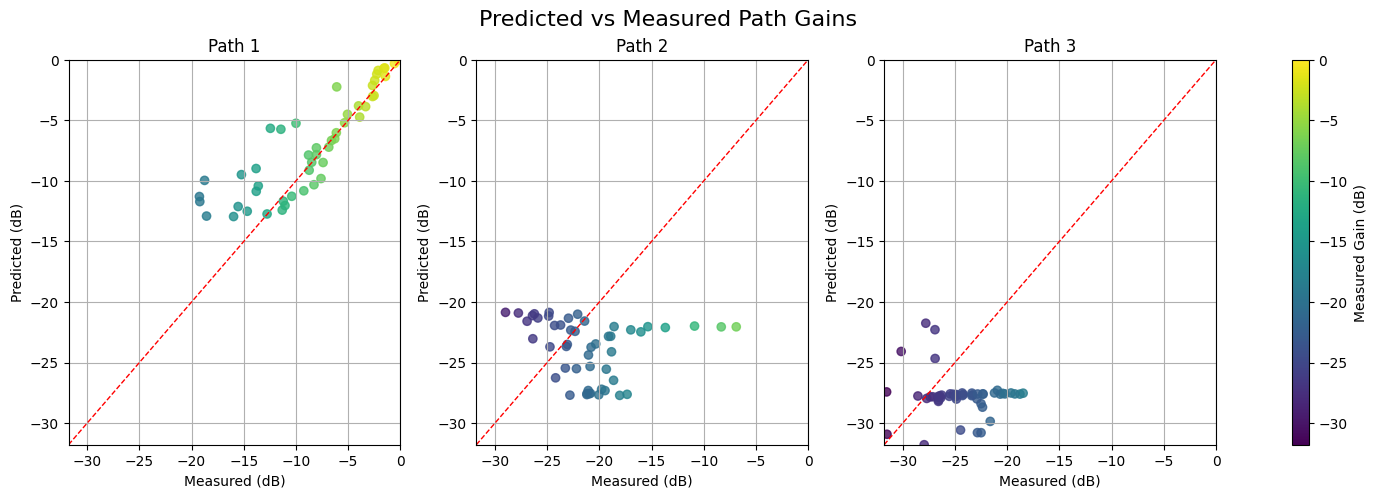

In [ ]:
# Assume `best_material_assignment` is a dict: {obj_name: material_type}

# Step 1: Assign the best materials to the scene
for obj_name, mat_type in best_material_assignment.items():
    LOS_scene.get(obj_name).radio_material = material_objects[mat_type]

# Step 2: Run the ray-tracing solver
solver = PathSolver()
paths = solver(
    scene=LOS_scene,
    max_depth=2,
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    refraction=False,
    samples_per_src=int(1e3)
)

# Step 3: Create ray dataset
df_best = create_ray_dataset(paths, LOS_merged_df, LOS_valid_positions, frequency)

# Step 4: Compare top-n paths
comparison_df_best, no_signal_n = find_top_n_paths(LOS_merged_df, df_best)

# Step 5: Normalize PGs (measurement and Sionna)
measurement_cols = [f"Strongest PG {i+1} (dB)" for i in range(3)]
sionna_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(3)]

merged_comparison_df_n = normalize_columns(comparison_df_best, measurement_cols)
comparison_df_best = normalize_columns(comparison_df_best, sionna_cols)

rmse_db = np.sqrt(np.mean((merged_comparison_df_n[measurement_cols].values - comparison_df_best[sionna_cols].values)**2, axis=0)) 
rmse_db = np.sum(rmse_db * weights)
print(f"Weighted RMSE for best combination (dB): {rmse_db:.3f}")
plot_comp_PG(comparison_df_best, n=N)


In [ ]:
import random
import pandas as pd
import numpy as np
from sionna.rt import ITURadioMaterial, PathSolver
import json

def optimize_materials(scene,merged_df, valid_positions ,num_iterations=2,save_path='material_optimization_results_LOS'):
    material_names = [
    "concrete", "brick", "wood", "glass", "ceiling_board",
    "chipboard", "plywood", "marble", "metal"
    ]
    best_rmse = float("inf")
    best_material_assignment = None
    best_df = None

    # Step 1: Create one material object per type (reuse later)
    material_objects = {}
    for mat_name in material_names:
        material_objects[mat_name] = ITURadioMaterial(
            name=f"{mat_name}_mat",
            itu_type=mat_name,
            scattering_coefficient=0.4,
            thickness=0.1
        )

    for it in range(num_iterations):
        # Step 2: Randomly assign materials to scene objects
        scene_assignment = {}
        for obj_name in scene.objects:
            mat_type = random.choice(material_names)
            mat_obj = material_objects[mat_type]
            scene.get(obj_name).radio_material = mat_obj
            scene_assignment[obj_name] = mat_type
        print("Starting ray tracing for iteration", it+1)
        # Step 3: Run ray-tracing solver
        solver = PathSolver()
        paths = solver(
            scene=scene,
            max_depth=2,
            los=True,
            specular_reflection=True,
            diffuse_reflection=True,
            refraction=False,
            samples_per_src=int(1e3)
        )
        print("Completed ray tracing for iteration", it+1)
        frequency=28.5e9
        # Step 4: Get ray dataset
        df = create_ray_dataset(paths, merged_df, valid_positions, frequency)

        # Step 5: Compare top-n paths with measurement
        comparison_df, no_signal_n = find_top_n_paths(merged_df, df)

        # Normalize measurement PG
        measurement_cols = [f"Strongest PG {i+1} (dB)" for i in range(3)]
        merged_comparison_df_n = normalize_columns(comparison_df, measurement_cols)

        # Normalize Sionna PG
        sionna_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(3)]
        comparison_df = normalize_columns(comparison_df, sionna_cols)

        # Step 6: Compute RMSE between top-3 paths
        #measurement_lin = 10**(merged_comparison_df_n[measurement_cols].values / 10)
        #sionna_lin = 10**(comparison_df[sionna_cols].values / 10)
        rmse_db = np.sqrt(np.mean((merged_comparison_df_n[measurement_cols].values - comparison_df[sionna_cols].values)**2, axis=0)) 
        print("\nRMSE for each Path:", rmse_db)
        weights = np.array([0.3, 0.4, 0.2])
        rmse_db = np.sum(rmse_db * weights)
        print(rmse_db)

        #print(f"Iteration {it+1}, RMSE = {rmse_db:.3f}")

        # Step 7: Save the best combination
        if rmse_db < best_rmse:
            best_rmse = rmse_db
            best_material_assignment = scene_assignment.copy()
            best_df = comparison_df.copy()

    print("\nBest RMSE:", best_rmse)
    print("Best material assignment:", best_material_assignment)
    plot_comp_PG(best_df, n=N)
    with open(f"{save_path}/best_material_assignment.json", "w") as f:
        json.dump(best_material_assignment, f, indent=4)

    # 8b: Save best RMSE to a text file
    with open(f"{save_path}/best_rmse.txt", "w") as f:
        f.write(f"{best_rmse}\n")

    # 8c: Save best comparison DataFrame as CSV
    best_df.to_csv(f"{save_path}/best_comparison_df.csv", index=False)

    print(f"Results saved in folder: {save_path}")
    return best_material_assignment, best_rmse, best_df


Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 929.04it/s]


2025-09-22 15:53:41 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 860.20it/s]


2025-09-22 15:53:52 WARN wrk1 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

Starting ray tracing for iteration 1
Completed ray tracing for iteration 1

RMSE for each Path: [3.06613893 8.31615529 5.20756364]
5.287816522555303

Best RMSE: 5.287816522555303
Best material assignment: {'ground': 'ceiling_board', 'building_0_rooftop': 'concrete', 'building_0_wall': 'chipboard', 'building_1_rooftop': 'wood', 'building_1_wall': 'chipboard', 'building_2_rooftop': 'ceiling_board', 'building_2_wall': 'glass', 'building_3_rooftop': 'concrete', 'building_3_wall': 'chipboard', 'building_4_rooftop': 'metal', 'building_4_wall': 'plywood', 'building_5_rooftop': 'plywood', 'building_5_wall': 'ceiling_board', 'building_6_rooftop': 'brick', 'building_6_wall': 'glass', 'building_7_rooftop': 'wood', 'building_7_wall': 'glass', 'building_8_rooftop': 'wood', 'building_8_wall': 'chipboard', 'building_9_rooftop': 'glass', 'building_9_wall': 'marble', 'building_10_rooftop': 'metal', 'building_10_wall': 'concrete', 'building_11_rooftop': 'wood', 'building_11_wall': 'glass', 'building_12_

/var/folders/72/2dlnb79j6ns37f30m_rkk9j40000gn/T/ipykernel_51978/460640940.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


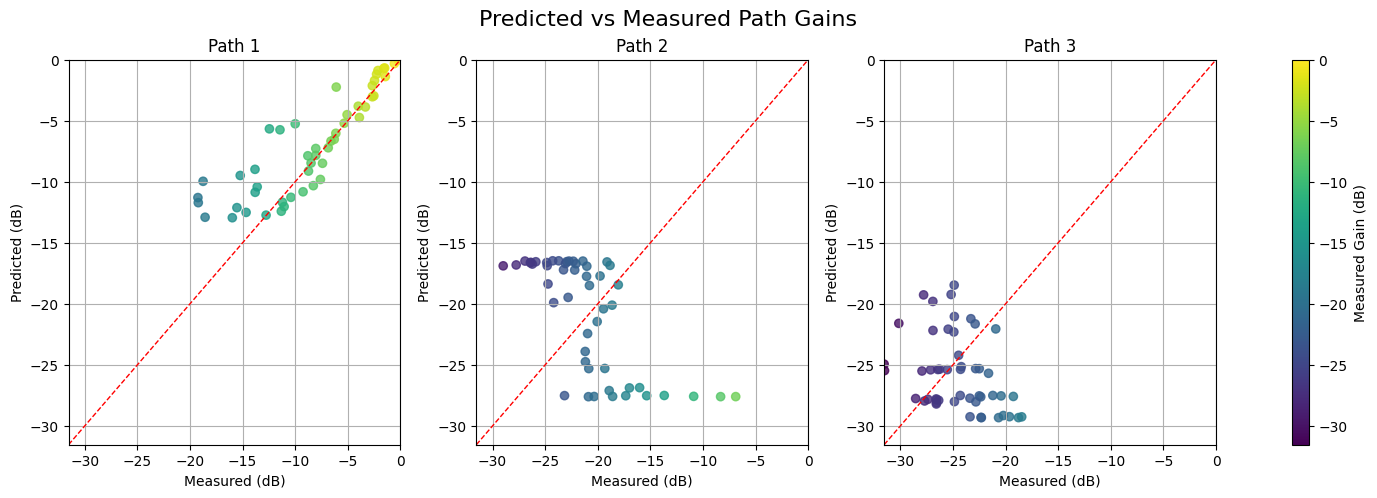

Results saved in folder: material_optimization_results_LOS


In [ ]:
NLOS_scene, NLOS_valid_positions = generate_scene(NLOS_merged_df)
LOS_scene, LOS_valid_positions = generate_scene(LOS_merged_df)
best_material_assignment, best_rmse, best_df = optimize_materials(LOS_scene,LOS_merged_df, LOS_valid_positions ,num_iterations=1,save_path='material_optimization_results_LOS')

In [ ]:
import json
import pandas as pd
with open("./material_optimization_results_LOS/best_material_assignment.json", "r") as f:
    best_material_assignment = json.load(f)
print(best_material_assignment)
with open("./material_optimization_results_LOS/best_rmse.txt", "r") as f:
    best_rmse = float(f.read().strip())
print("Best weighted RMSE:", best_rmse)
best_df = pd.read_csv("./material_optimization_results_LOS/best_comparison_df.csv")
print(best_df.head())

{'ground': 'ceiling_board', 'building_0_rooftop': 'concrete', 'building_0_wall': 'chipboard', 'building_1_rooftop': 'wood', 'building_1_wall': 'chipboard', 'building_2_rooftop': 'ceiling_board', 'building_2_wall': 'glass', 'building_3_rooftop': 'concrete', 'building_3_wall': 'chipboard', 'building_4_rooftop': 'metal', 'building_4_wall': 'plywood', 'building_5_rooftop': 'plywood', 'building_5_wall': 'ceiling_board', 'building_6_rooftop': 'brick', 'building_6_wall': 'glass', 'building_7_rooftop': 'wood', 'building_7_wall': 'glass', 'building_8_rooftop': 'wood', 'building_8_wall': 'chipboard', 'building_9_rooftop': 'glass', 'building_9_wall': 'marble', 'building_10_rooftop': 'metal', 'building_10_wall': 'concrete', 'building_11_rooftop': 'wood', 'building_11_wall': 'glass', 'building_12_rooftop': 'marble', 'building_12_wall': 'marble', 'building_13_rooftop': 'wood', 'building_13_wall': 'ceiling_board', 'building_14_rooftop': 'glass', 'building_14_wall': 'glass', 'building_15_rooftop': 'ch

In [ ]:
# Adding low, medium, high density cars to the scene
NLOS_scene, NLOS_valid_positions = generate_scene(NLOS_merged_df)
NLOS_scene = add_random_cars_to_scene(NLOS_scene, num_cars=10, area_radius=100, valid_positions=NLOS_valid_positions)  # Low density

LOS_scene, LOS_valid_positions = generate_scene(LOS_merged_df)
LOS_scene = add_random_cars_to_scene(LOS_scene, num_cars=10, area_radius=100, valid_positions=LOS_valid_positions)  # Low density

NLOS_paths = radio_scene(NLOS_scene)
LOS_paths = radio_scene(LOS_scene)

NLOS_df = create_ray_dataset(NLOS_paths, NLOS_merged_df, NLOS_valid_positions, frequency=28.5e9)
LOS_df = create_ray_dataset(LOS_paths, LOS_merged_df, LOS_valid_positions, frequency=28.5e9)

N = 3
NLOS_comparison_df_n, NLOS_no_signal_n = find_top_n_paths(NLOS_merged_df, NLOS_df, n=N)
LOS_comparison_df_n, LOS_no_signal_n = find_top_n_paths(LOS_merged_df, LOS_df, n=N)

measurement_cols = [f"Strongest PG {i+1} (dB)" for i in range(3)]
sionna_cols = [f"Strongest Sionna PG {i+1} (dB)" for i in range(3)]

merged_comparison_df_n = normalize_columns(NLOS_comparison_df_n, measurement_cols)
comparison_df_best = normalize_columns(LOS_comparison_df_n, sionna_cols)

NameError: name 'generate_scene' is not defined